# Part 1 - MNIST

## Explore data

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

In [2]:
mnist = np.load('data/mnist.npz')

In [3]:
X = mnist['data'].astype('float32')
y = mnist['target'].astype('int64')

print(X.shape, y.shape)

(70000, 784) (70000,)


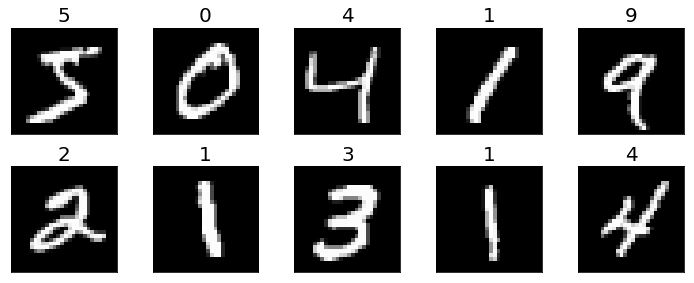

In [4]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
fig.patch.set_alpha(0)
for idx, ax in enumerate(axes.flatten()):
    ax.imshow(X[idx].reshape(28, 28), cmap='gray')
    ax.set_title(y[idx], fontsize=20)
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
fig.savefig('images/mnist_example.png')

## Simple Neutral Model

In [5]:
import torch.nn as nn

class SimpleFeedforward(nn.Module):
    def __init__(self, dropout=0.5):
        super().__init__()
        self.module = nn.Sequential(
            nn.Linear(784, 98),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(98, 10)
        )
    def forward(self, X):
        return self.module(X)

In [6]:
from sklearn.model_selection import train_test_split

X_scaled = X / X.max()

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42)

In [7]:
from skorch import NeuralNet

net = NeuralNet(
    SimpleFeedforward,
    criterion=nn.CrossEntropyLoss,
    max_epochs=10,
    lr=0.3,
    device='cuda', # comment out to run on cpu
)

In [8]:
_ = net.fit(X_train, y_train)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5848        0.3388  0.4810
      2        0.3240        0.2524  0.4822
      3        0.2695        0.1964  0.4789
      4        0.2396        0.1776  0.4707
      5        0.2205        0.1497  0.4708
      6        0.2057        0.1380  0.4715
      7        0.1904        0.1279  0.4715
      8        0.1838        0.1298  0.4729
      9        0.1784        0.1227  0.4781
     10        0.1662        0.1343  0.4856


In [9]:
net.set_params(max_epochs=5)
_ = net.partial_fit(X_train, y_train)

     11        0.1630        0.1172  0.4873
     12        0.1547        0.1295  0.4839
     13        0.1532        0.1119  0.4788
     14        0.1474        0.1074  0.4761
     15        0.1471        0.1071  0.4745


## History

In [10]:
len(net.history)

15

In [11]:
net.history[-1, 'valid_loss']

0.10714734790438697

In [12]:
net.history[-2:, 'train_loss']

[0.14743910779271807, 0.14714258934202648]

## Callbacks

### EpochScoring

In [13]:
from sklearn.metrics import make_scorer
from skorch.callbacks import EpochScoring

def accuracy_argmax(y_true, y_pred):
    return np.mean(y_true == np.argmax(y_pred, -1))
accuracy_argmax_scorer = make_scorer(accuracy_argmax)

epoch_acc = EpochScoring(
    accuracy_argmax_scorer,
    name='valid_acc',
    lower_is_better=False)

In [14]:
net = NeuralNet(
    SimpleFeedforward,
    criterion=nn.CrossEntropyLoss,
    max_epochs=10,
    lr=0.3,
    device='cuda',
    callbacks=[epoch_acc]
)

In [15]:
_ = net.fit(X_train, y_train)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5757       0.8978        0.3351  0.4749
      2        0.3227       0.9250        0.2394  0.4698
      3        0.2710       0.9431        0.1848  0.4697
      4        0.2408       0.9446        0.1749  0.4701
      5        0.2201       0.9554        0.1432  0.4694
      6        0.2081       0.9588        0.1374  0.4787
      7        0.1909       0.9570        0.1353  0.4831
      8        0.1845       0.9591        0.1349  0.4829
      9        0.1798       0.9583        0.1350  0.4847
     10        0.1719       0.9663        0.1130  0.4838


In [16]:
y_pred = net.predict(X_test)
print(y_pred.shape)
print('test accuracy:', accuracy_argmax(y_test, y_pred))

(17500, 10)
test accuracy: 0.9637142857142857


## Integration with sklearn

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

In [13]:
pipe = Pipeline([
    ('min_max', MinMaxScaler()),
    ('net', net)
])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)
_ = pipe.fit(X_train, y_train)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5839       0.8897        0.3528  0.5927
      2        0.3270       0.9260        0.2447  0.4988
      3        0.2706       0.9443        0.1809  0.4852
      4        0.2416       0.9457        0.1711  0.4832
      5        0.2239       0.9485        0.1704  0.4846
      6        0.2112       0.9477        0.1692  0.4858
      7        0.2000       0.9609        0.1320  0.4863
      8        0.1840       0.9570        0.1430  0.4839
      9        0.1804       0.9643        0.1194  0.4849
     10        0.1721       0.9641        0.1207  0.4823


In [16]:
from sklearn.model_selection import GridSearchCV

pipe.set_params(net__verbose=0)
param_grid = {
    'net__module__dropout': [0.2, 0.5, 0.8]
}

gs = GridSearchCV(pipe, param_grid, 
                  scoring=accuracy_argmax_scorer, 
                  cv=3, verbose=3)

In [17]:
_ = gs.fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] net__module__dropout=0.2 ........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  net__module__dropout=0.2, score=0.9665723836461816, total=   5.5s
[CV] net__module__dropout=0.2 ........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s


[CV]  net__module__dropout=0.2, score=0.9635709081558308, total=   5.3s
[CV] net__module__dropout=0.2 ........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.7s remaining:    0.0s


[CV]  net__module__dropout=0.2, score=0.970385291218446, total=   5.4s
[CV] net__module__dropout=0.5 ........................................
[CV]  net__module__dropout=0.5, score=0.9610868260906831, total=   5.4s
[CV] net__module__dropout=0.5 ........................................
[CV]  net__module__dropout=0.5, score=0.9577851112158745, total=   5.3s
[CV] net__module__dropout=0.5 ........................................
[CV]  net__module__dropout=0.5, score=0.9638280546864956, total=   5.4s
[CV] net__module__dropout=0.8 ........................................
[CV]  net__module__dropout=0.8, score=0.9362732493357333, total=   5.4s
[CV] net__module__dropout=0.8 ........................................
[CV]  net__module__dropout=0.8, score=0.9336990528436121, total=   5.4s
[CV] net__module__dropout=0.8 ........................................
[CV]  net__module__dropout=0.8, score=0.9435563365190931, total=   5.4s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   52.4s finished


In [289]:
print("best score:", gs.best_score_)
print("best_params", gs.best_params_)

best score: 0.9651
best_params {'net__module__dropout': 0.2}
